# **Ex3 - Unsupervised learning**

## Names and IDs

1.   208391037 - Nadav Arbel
2.   207060914 - Yuval Gorelik


In this assignemnt you will practice unsupervised methods we saw in class, and specifically running K-means and visualizing the data using PCA.

In this assignment you will learn a few more things:

1.   Load local files
2.   Load data from Kaggle
3. Use Scikit-learn K-means
4. Use Scikit-learn PCA
5. Some visulaization
6. Evaluate the performance of the clustering using Elbow methods, Siouhette analysis and accuracy (as we have true labels)

Note:
* Read the complete task before implementing.
* Reuse code, write functions.

## Import All Packages
Add all imports needed for this notebook to run

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from keras.datasets import mnist

# Text Clustering And Dimension Reduction

In this exercise you will cluster fake news using `k-means` and visualize the clustering using PCA.

**Import the Fake News Dataset from Kaggle**

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below and click the upload button to upload kaggle.json to your Colab runtime.

After uploading the kaggle.json the fake news dataset will be copy to the enviroment in the '/content' directory. You will see the two files 'Fake.csv' and 'True.csv'.

For more about the dataset you can read [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

In [2]:
from google.colab import files

# upload kaggle.json file using user prompt
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# extract the files
!unzip '/content/fake-and-real-news-dataset.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes
 88% 36.0M/41.0M [00:00<00:00, 54.9MB/s]
100% 41.0M/41.0M [00:00<00:00, 86.0MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


## 1. Read the csv files and create one single dataframe (5 points)

*   Create a dataframe which is the join of the two files 'Fake.csv' and 'True.csv'.
*   Extract the 'text' column from each dataframe (droping title, subject and date columns).
*   Create a single dataframe containing a text column and a label column (fake=0, real=1).

In [3]:
true_df = pd.read_csv('/content/True.csv')
fake_df = pd.read_csv('/content/Fake.csv')
true_df.insert(4, 'label', 1)
fake_df.insert(4, 'label', 0)
true_df = true_df.drop(columns=['title', 'subject', 'date'])
fake_df = fake_df.drop(columns=['title', 'subject', 'date'])
TrueAndFalse = pd.concat([true_df, fake_df], ignore_index=True)

## 2. Cluster the samples into 2 clusters (real and fake) (15 points)

*   Generate TF-IDF features by applying the TfidfVectorizer preprocessor using 1000 features (`max_features=1000`) and remove English stop words.
* Scale the data.
*    Apply k-Means algorithm on the TF-IDF features using n_clusters=2.

In [4]:
tfidf = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 1000, stop_words = 'english')
text = tfidf.fit_transform(TrueAndFalse.text).toarray()

standScaler = StandardScaler(with_mean=False)
scaledText = standScaler.fit_transform(text)

kmeans = KMeans(n_clusters=2).fit(scaledText)

## 3. Visualize using scatter plot (20 points)
The data is high dimensional, so for visualization purpose, we will perform a dimensionality reduction suing PCA.

* Apply PCA
*   Visualize the clustering in 2d using first two PCs.
*   Visualize the clustering in 3d using first three PCs.

Notes:

*   In clustering visualization it's important to also visualize the centroids.
* Visualize using matplotlib scatter function. It can be used to plot 2D or 3D scatter plots.
* Color the points according to the true labels.

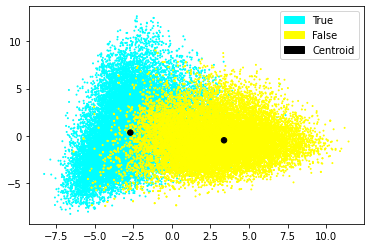

In [5]:
pca = PCA()
data_and_centroids = np.concatenate((scaledText, kmeans.cluster_centers_))
Xt = pca.fit_transform(data_and_centroids)

# creating colors list and sizes list for better visualization
labels = getattr(TrueAndFalse.label, "tolist")()
colors = []
for label in labels:
  if label == 0:
    colors.append('yellow')
  elif label == 1:
    colors.append('aqua')
colors.append('black')
colors.append('black')
sizes = [1 for x in range(len(Xt[:-2,0]))]
sizes.append(30)
sizes.append(30)

# Show first two principal components
plt.scatter(Xt[:,0], Xt[:,1],s=sizes, c=colors)
true_head = mpatches.Patch(color='aqua', label='True')
false_head = mpatches.Patch(color='yellow', label='False')
centroid_head = mpatches.Patch(color='black', label='Centroid')
plt.legend(handles=[true_head, false_head, centroid_head])
plt.show()

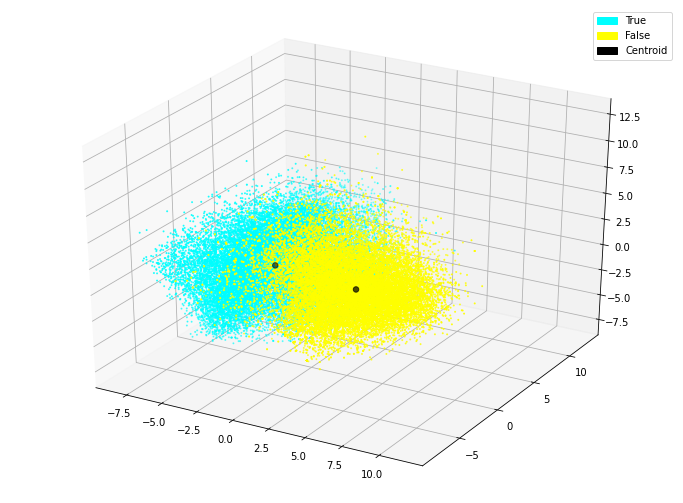

In [6]:
# Show first three principal components

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')
ax.legend(handles=[true_head, false_head, centroid_head])
ax.scatter(Xt[:,0], Xt[:,1], zs=Xt[:,2], s=sizes, color=colors);

## 4. Performance evaluation (15 points)
### How did our clustering perform against the real labels?

We do have the true lables (fake/real), but we don't know which cluster correspond to which label. Therefore, we check the two options:

*   Define cluster 1 as fake and cluster 2 as real. What is the accuracy?
*   Define cluster 1 as true and cluster 2 as fake. What is the accuracy?

In [8]:
pred_labels = kmeans.labels_
# the kMeans algorithm labled the whole data into 2 clusters, 0 and 1 (as k=2)
# at first, lets check the accuraccy with 1 as True and 0 as False:
print("Cluster 1 as fake and cluster 2 as real:" + str(accuracy_score(labels, pred_labels)))

# now, let's check the accuraccy on the opposite option:
# 0 as True and 1 as False
for x in range(len(pred_labels)):
  if pred_labels[x] == 0:
    pred_labels[x] = 1
  else:
    pred_labels[x] = 0

print("Cluster 2 as fake and cluster 1 as real:" + str(accuracy_score(labels, pred_labels)))

Cluster 1 as fake and cluster 2 as real:0.8704619359436946
Cluster 2 as fake and cluster 1 as real:0.1295380640563054


####After checking the acuuracy over the 2 options, 
####we understand that the algorithm classified cluster 2 as fake and claster 1 as real

## 5. Find optimal `k` (20 points)
What is the best k for clustering?

* Cluster using a range of `k` (up to 20) and compare the SSD and the Silhouette values for every k.
* Plot SSD vs. k and Silhouette score vs. k.

Notes:
* You can get the SSD of a clustering using the `inertia_` attribute of the model.
* Silhouette score using `silhouette_score` function from `sklearn.metrics`. This function accept the model and the data.
* Computing Silhouette may takes long time. Estimate the Silhouette using a sample of 300 samples uisng the argument `sample_size=300`.

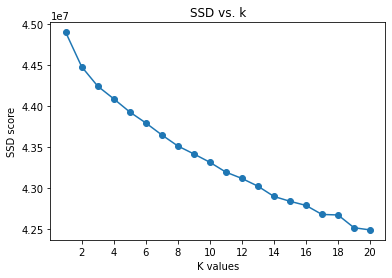

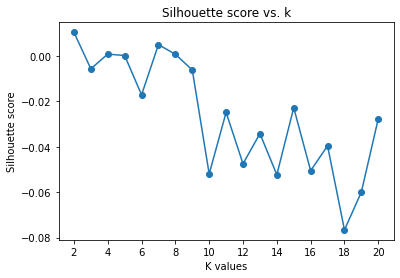

In [109]:
ssd_score = []
silhouette_scores = []

for k in range(1, 21):    
    # Run the Kmeans algorithm
    results = KMeans(n_clusters=k).fit(scaledText)
    ssd_score.append(results.inertia_)
    if k == 1: continue
    silhouette_scores.append(silhouette_score(scaledText, results.labels_, sample_size=300))

k_values = [x+1 for x in range(20)]

plt.plot(k_values, ssd_score, '-o')
plt.xlabel('K values')
plt.ylabel('SSD score')
plt.title('SSD vs. k')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.show()

plt.plot(k_values[1:], silhouette_scores, '-o')
plt.xlabel('K values')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs. k')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.show()

### 6. What is the optimal k for clustering? (10 points)

* Explain.
* If optimal k!=2 what can be a good explanation for this?

It seems that the opimal k-value is 2: the silhouette score is heighest when k=2 (the higher the score the better). When we look on the SSD graph we can't see the "elbow" very well, so let's print the same graph but now for k values between 2-7:

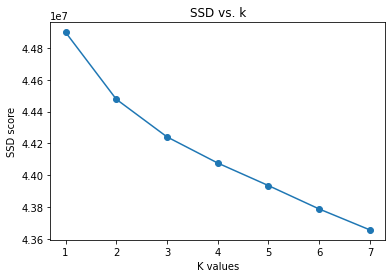

In [14]:
plt.plot(k_values[0:7], ssd_score[0:7], '-o')
plt.xlabel('K values')
plt.ylabel('SSD score')
plt.title('SSD vs. k')
plt.xticks(k_values[0:7])
plt.show()

Also in the narrow graph it seems that 2 is the optimal value, but just to be sure we will manually calculate the difference between each K



In [15]:
max_k = 0
max_ssd = 0
for i in range(len(ssd_score)-1):
  if (ssd_score[i] - ssd_score[i+1]) > max_ssd:
    max_ssd = ssd_score[i] - ssd_score[i+1]
    max_k = i+2
print("The maximum difference is when K is equal to " + str(max_k))

The maximum difference is when K is equal to 2


####After all the tests we can be sure that **the optimum K value is 2**

# 7. PCA then k-means (15 points)
This time, lets try to change the order.
1. Generate TF-IDF 1000 features
2. Run PCA
3. Run k-means
4. Plot 2D and 3D scatter plots
5. Estimate the accuracy according to true labels.
6. Explain how is it compared to the previous approach, where clustering is performed w/o PCA.

Note:
* When you compute the PCA, don't limit to first PCs, but use all of them.

In [14]:
tfidf = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 1000, stop_words = 'english')
text = tfidf.fit_transform(TrueAndFalse.text).toarray()

pca = PCA()
pca_results = pca.fit_transform(text)

kmeans = KMeans(n_clusters=2)
results = kmeans.fit(pca_results)
cluster_centers = results.cluster_centers_

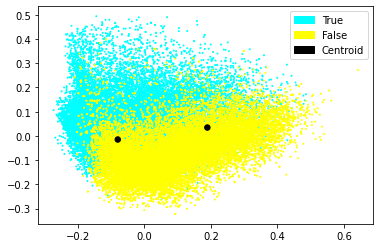

In [11]:
Xt = np.concatenate((pca_results, cluster_centers))

# Show first two principal components
plt.scatter(Xt[:,0], Xt[:,1],s=sizes, c=colors)
true_head = mpatches.Patch(color='aqua', label='True')
false_head = mpatches.Patch(color='yellow', label='False')
centroid_head = mpatches.Patch(color='black', label='Centroid')
plt.legend(handles=[true_head, false_head, centroid_head])
plt.show()

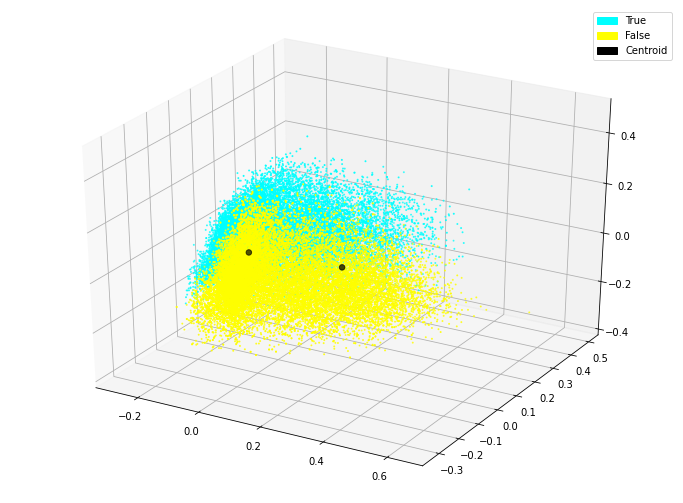

In [12]:
# Show first three principal components

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')
ax.legend(handles=[true_head, false_head, centroid_head])
ax.scatter(Xt[:,0], Xt[:,1], zs=Xt[:,2], s=sizes, color=colors);

In [13]:

# the kMeans algorithm labled the whole data into 2 clusters, 0 and 1 (as k=2)
# at first, lets check the accuraccy with 1 as True and 0 as False:
print(accuracy_score(labels, pred_labels))

# now, let's check the accuraccy on the opposite option:
# 0 as True and 1 as False
for x in range(len(pred_labels)):
  if pred_labels[x] == 0:
    pred_labels[x] = 1
  else:
    pred_labels[x] = 0

print(accuracy_score(labels, pred_labels))

0.1295380640563054
0.8704619359436946


####We used PCA without setting n_components so it stays on default which in our case leaves it at 1000 features so there seems to be almost no change in accuracy results compared to running in previous questions

# Bonus (10 points)
Redo the same analysis, but this time using the MNIST data set. Notice that this time there are actually 10 'true' clusters.

1. What is the accuracy of the clustering when using k=10? \\
   * When for computing the accuracy of 10 classes, first you need to define what is the label of each cluster. Do that by majority votes. In theory, you may get two or more clusters with the same labels. We will ignore that for now.
2. What is the optimal k?
3. How do the results changes if you first run PCA?

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
X = X.reshape(X.shape[0], 784)

11501568/11490434 [==============================] - 0s 0us/step


In [16]:
standScaler = StandardScaler(with_mean=False)
scaledX = standScaler.fit_transform(X)

kmeans = KMeans(n_clusters=10).fit(scaledX)

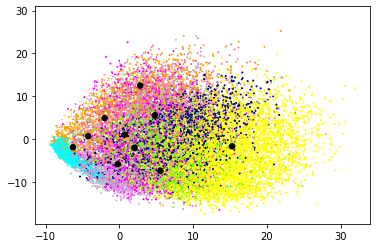

In [17]:
pca = PCA()
data_and_centroids = np.concatenate((scaledX, kmeans.cluster_centers_))
Xt = pca.fit_transform(data_and_centroids)

# creating colors list and sizes list for better visualization
labels = y
sizes = [1 for x in range(len(labels))]
sizes.extend([30 for x in range(10)])
colors = []
for label in labels:
  if label == 0:
    colors.append('yellow')
  elif label == 1:
    colors.append('aqua')
  elif label == 2:
    colors.append('lawngreen')
  elif label == 3:
    colors.append('magenta')
  elif label == 4:
    colors.append('lightcoral')
  elif label == 5:
    colors.append('silver')
  elif label == 6:
    colors.append('navy')
  elif label == 7:
    colors.append('white')
  elif label == 8:
    colors.append('violet')
  elif label == 9:
    colors.append('orange')
    
colors.extend(['black' for x in range(10)])

# Show first two principal components
plt.scatter(Xt[:,0], Xt[:,1],s=sizes, c=colors)
plt.show()

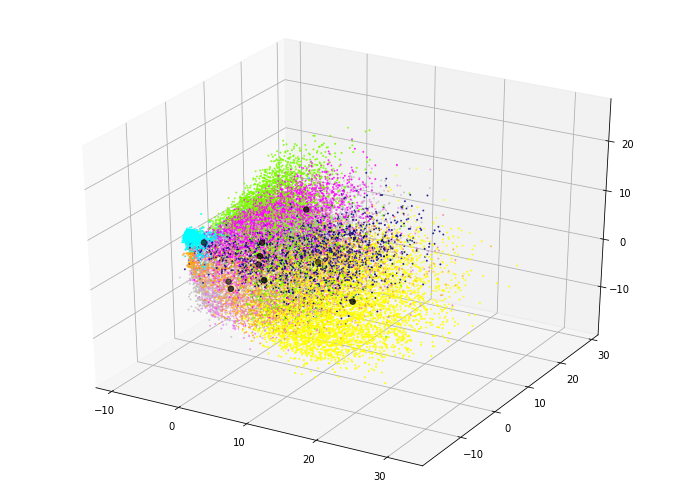

In [18]:
# Show first three principal components

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(Xt[:,0], Xt[:,1], zs=Xt[:,2], s=sizes, color=colors);

In [19]:
reference_labels = {}
# For loop to run through each label of cluster label
for i in range(len(np.unique(kmeans.labels_))):
  index = np.where(kmeans.labels_ == i,1,0)
  num = np.bincount(y[index==1]).argmax()
  reference_labels[i] = num
print('The next dict represent the cluster number and the digit it represent, as key=cluster number and value=digit')
# Now we need to refer each label to the digit the algorithm tried to match to
number_labels = np.array([0 for x in range(len(kmeans.labels_))])
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

print("The accuracy score when k=10 is:")
print(accuracy_score(y, number_labels))

The next dict represent the cluster number and the digit it represent, as key=cluster number and value=digit
The accuracy score when k=10 is:
0.5259714285714285


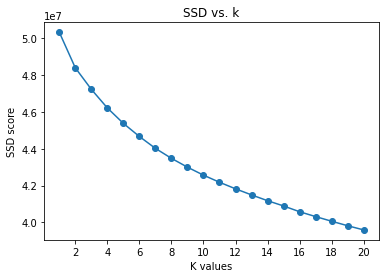

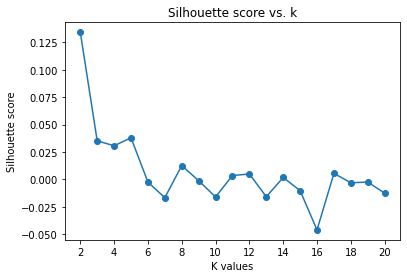

In [79]:
ssd_score = []
silhouette_scores = []

for k in range(1, 21):    
    # Run the Kmeans algorithm
    results = KMeans(n_clusters=k).fit(scaledX)
    ssd_score.append(results.inertia_)
    if k == 1: continue
    silhouette_scores.append(silhouette_score(scaledX, results.labels_, sample_size=300))

k_values = [x+1 for x in range(20)]

plt.plot(k_values, ssd_score, '-o')
plt.xlabel('K values')
plt.ylabel('SSD score')
plt.title('SSD vs. k')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.show()

plt.plot(k_values[1:], silhouette_scores, '-o')
plt.xlabel('K values')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs. k')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.show()

####The optimal K value seen by the results is 5, because in a graph showing the SSD values there is no "elbow", and in a graph with Silhouette values the highest value is obtained when K is equal to 5. This is probably due to the similarity between different digits which he classifies into the same cluster

In [22]:
pca = PCA()
pca_results = pca.fit_transform(X)
kmeans = KMeans(n_clusters=10)
results = kmeans.fit(pca_results)
cluster_centers = results.cluster_centers_
pred_labels = results.labels_

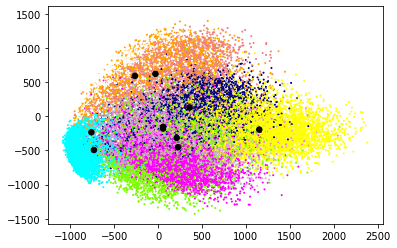

In [23]:
# pca = PCA(n_components=2)
Xt = np.concatenate((pca_results, cluster_centers))
plt.scatter(Xt[:,0], Xt[:,1],s=sizes, c=colors)
plt.show()

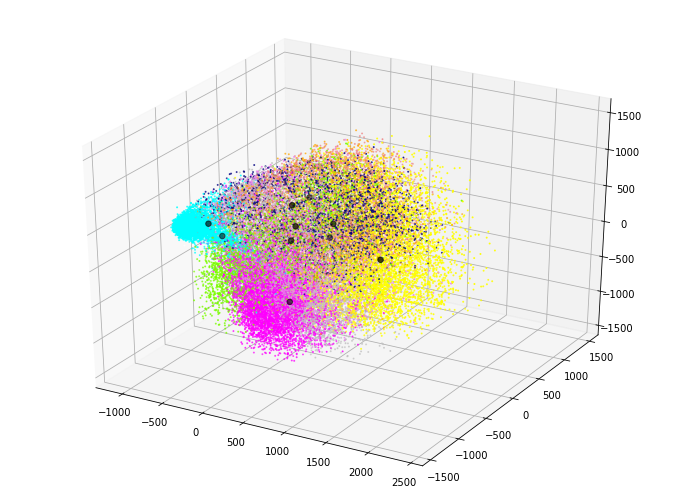

In [24]:
# Show first three principal components

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(Xt[:,0], Xt[:,1], zs=Xt[:,2], s=sizes, color=colors);

In [25]:
reference_labels = {}
# For loop to run through each label of cluster label
for i in range(len(np.unique(pred_labels))):
  index = np.where(pred_labels == i,1,0)
  num = np.bincount(y[index==1]).argmax()
  reference_labels[i] = num
print('The next dict represent the cluster number and the digit it represent, as key=cluster number and value=digit')
print(reference_labels)
# Now we need to refer each label to the digit the algorithm tried to match to
number_labels = np.array([0 for x in range(len(kmeans.labels_))])
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

print("The accuracy score when k=10 is:")
print(accuracy_score(y, number_labels))

The next dict represent the cluster number and the digit it represent, as key=cluster number and value=digit
{0: 0, 1: 4, 2: 1, 3: 6, 4: 3, 5: 8, 6: 7, 7: 6, 8: 2, 9: 1}
The accuracy score when k=10 is:
0.5850285714285715


####As in the previous test we performed, here too there does not seem to be a big difference in the results following the order of activation of the functions for the same reasons